## Import

In [3]:
import docker
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pyKriging
from pyKriging.krige import kriging  
from pyKriging.samplingplan import samplingplan
client = docker.from_env()
from sklearn.gaussian_process.kernels import RBF,ExpSineSquared, Matern,RationalQuadratic, ConstantKernel as C
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from pyDOE import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

## Def functions

In [4]:
def set_parameter(alpha=1,delta=1,beta=1,gamma=1,DefaultComp_predator=1, DefaultComp_prey=1.5, time_step='0.5s'):
    with open('inputs/solver-config.json') as json_file:
        data = json.load(json_file)
        data['data']['Inputs']['QuickOverrides']['inputs']['alpha']=alpha
        data['data']['Inputs']['QuickOverrides']['inputs']['delta']=delta
        data['data']['Inputs']['QuickOverrides']['inputs']['beta']=beta
        data['data']['Inputs']['QuickOverrides']['inputs']['gamma']=gamma
        data['data']['Inputs']['QuickOverrides']['inputs']['DefaultComp.predator']=DefaultComp_predator
        data['data']['Inputs']['QuickOverrides']['inputs']['DefaultComp.prey']=DefaultComp_prey
        data['data']['SolveOptions']['ode']['tstep']= time_step
    with open('inputs/solver-config.json', 'w') as outfile:
        json.dump(data, outfile)

In [5]:
def run_model():
    client.containers.run(image="registry.novadiscovery.net/students/model-emulator/model-solver:v0-4-3-1", command="/inputs/solver-config.json --loc \"/Inputs/RawModel=/inputs/raw-model.json\" --loc=\"/Outputs/Results/0=/outputs/{simulation_id}.json\" --var simulation_id=1", volumes=[f"{os.getcwd()}/inputs:/inputs", f"{os.getcwd()}/outputs:/outputs"])

In [6]:
def plot_outputs(id=1,plot_pred=True,plot_prey=True):
    with open('outputs/1.json') as json_file:
        data = json.load(json_file)
    prey_data = data['DefaultComp.prey']['resVals']
    predator_data = data['DefaultComp.predator']['resVals']
    time = data['time']['resVals']
    
    
    
    if plot_prey:
        plt.plot(time,prey_data,label='prey '+str(id))
    if plot_pred:
        plt.plot(time,predator_data,label='predator '+str(id))
    plt.legend()

In [7]:
def get_outputs(id=1):
    with open('outputs/'+str(id)+'.json') as json_file:
        data = json.load(json_file)
    prey_data = data['DefaultComp.prey']['resVals']
    predator_data = data['DefaultComp.predator']['resVals']
    time = data['time']['resVals']
    
    with open('inputs/solver-config.json') as json_file:
        data = json.load(json_file)
        alpha = data['data']['Inputs']['QuickOverrides']['inputs']['alpha']
        delta = data['data']['Inputs']['QuickOverrides']['inputs']['delta']
        beta = data['data']['Inputs']['QuickOverrides']['inputs']['beta']
        gamma = data['data']['Inputs']['QuickOverrides']['inputs']['gamma']
    output_data = pd.DataFrame({'time':time,
                               'prey_data':prey_data,
                               'predator_data':predator_data,
                               'alpha':alpha,
                               'delta':delta,
                               'beta':beta,
                               'gamma':gamma})
    return output_data

## Run model 

In [8]:
set_parameter(alpha=0.375,delta=0.375, beta= 0.625,gamma = 0.125 ,DefaultComp_prey=0.2,time_step='0.1s')
run_model()
outputs = get_outputs()
print(len(outputs['time']))
plot_outputs()

FileNotFoundError: [Errno 2] No such file or directory: 'inputs/solver-config.json'

## Kriging 1D

In [58]:
number_of_sample = 50
sampled_prey_data = outputs.reindex(np.random.permutation(outputs.index))[['time','prey_data']].sample(n=number_of_sample)

In [59]:
from time import time
t1 = time()
X = sampled_prey_data['time'].values.reshape((number_of_sample,1))
y = sampled_prey_data['prey_data'].values
k_1d = kriging(X, y, name='simple')  
k_1d.train()
t2= time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  6.96884822845459  for  50  points


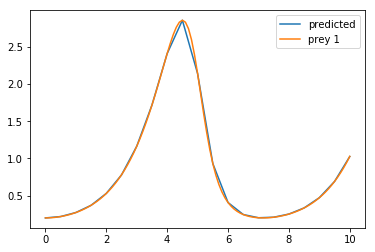

In [60]:
y=[]
time = np.linspace(0,10,21)
for i in time:
    y.append(k_1d.predict([i]))
set_parameter(alpha=1, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

## Kriging 2D

In [61]:
output_data_frame = pd.DataFrame()
for i in range(2,10):
    set_parameter(alpha=i/10,DefaultComp_prey=0.2,time_step='0.1s')
    run_model()
    output_data = get_outputs()
    output_data_frame = pd.concat([output_data_frame, output_data],ignore_index=True)

In [62]:
number_of_sample_2d = 100
sampled_prey_data = output_data_frame.reindex(np.random.permutation(output_data_frame.index))[['time','alpha','prey_data']].sample(n=number_of_sample_2d) 

In [63]:
# Now that we have our initial data, we can create an instance of a Kriging model
from time import time
t1 = time()
X = sampled_prey_data[['time','alpha']].values
y = sampled_prey_data['prey_data'].values
k_2d = kriging(X, y, name='simple')  
k_2d.train()
t2= time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  16.304647207260132  for  100  points


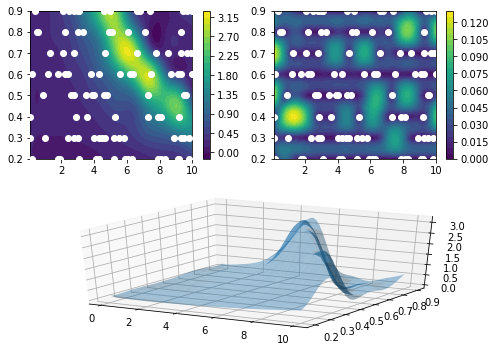

In [64]:
k_2d.plot()

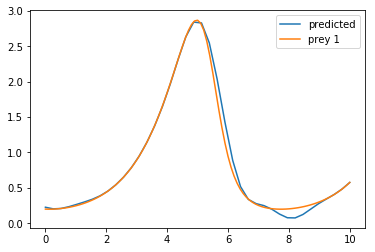

In [65]:
y=[]
time = np.linspace(0,10,40)
for i in time:
    y.append(k_2d.predict([i,0.9]))
set_parameter(alpha=0.9, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)


## Kriging 3D

In [66]:
def sampled_data(number_of_sample=100, sample_type='lhs'):
    if sample_type == 'lhs':
        sampling = lhs(3, samples=number_of_sample, criterion='cm')
        sampling[:,0]=np.round(sampling[:,0]*10,1)

    output_data_frame = pd.DataFrame()
    for i in range (len(sampling)):
        set_parameter(alpha=sampling[i,1],delta=sampling[i,2],DefaultComp_prey=0.2,time_step='0.1s')
        run_model()
        output_data = get_outputs()
        output_data_frame = pd.concat([output_data_frame, output_data],ignore_index=True)
    output_array = output_data_frame.values
    output_array[:,0]=np.round(output_data_frame.values[:,0],1)
    sampled_data = [row for row in output_array if row[[0,3,4]].tolist() in sampling.tolist()]
    sampled_data_df = pd.DataFrame(sampled_data,columns=['time','prey_data','predator_data','alpha','delta','beta','gamma'])
    return sampled_data_df

In [68]:
sampled_data_df = sampled_data(number_of_sample=400)

In [ ]:
from time import time
t1 = time()
X = sampled_data_df[['time','alpha','delta']].values
y =sampled_data_df['prey_data'].values
k_3d = kriging(X, y, name='simple')  
k_3d.train()
number_of_new_points = 3
#input_points = k_3d.infill(number_of_new_points)
#new_points = add_point(input_points)
#for i in range (number_of_new_points):
#    k_3d.addPoint(new_points[['time','alpha','delta']].values[i],new_points['prey_data'].values[i])
#    k_3d.train()
t2= time()
print("time to train : ",t2-t1," for ", len(X), " points")

In [ ]:
k_3d.infill(3)

## some plot examples

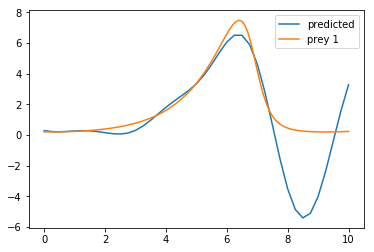

In [70]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(k_3d.predict([i,0.8,0.5]))
set_parameter(alpha=0.8, delta=0.5, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

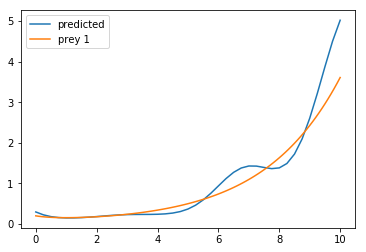

In [71]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(k_3d.predict([i,0.4,0.5]))
set_parameter(alpha=0.4, delta=0.5, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

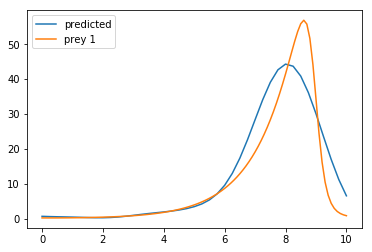

In [72]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(k_3d.predict([i,0.8,0.1]))
set_parameter(alpha=0.8, delta=0.1, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

## Test with sklearn

Split into train and test data_set

In [102]:
train, test = train_test_split(sampled_data_df.values,test_size=0.2)
train_df = pd.DataFrame(train,columns=['time','prey_data','predator_data','alpha','delta','beta','gamma'])
test_df =  pd.DataFrame(test,columns=['time','prey_data','predator_data','alpha','delta','beta','gamma'])

### RBF

In [103]:
from time import time

t1 =time()
X = train_df[['time','alpha','delta']].values
y =train_df['prey_data'].values
kernel =RBF([0.5,0.5,0.5], (1e-2, 1e2))
gp_rbf = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_rbf.fit(X, y)
t2=time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  88.94181394577026  for  320  points


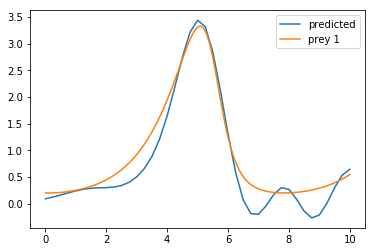

In [104]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(gp_rbf.predict([[i,0.9,0.9]]))
set_parameter(alpha=0.9, delta=0.9, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

#### Precision : 

In [105]:
y_pred = gp_rbf.predict(test_df[['time','alpha','delta']].values)
y_true = test_df['prey_data'].values
mse(y_true,y_pred)

34.617998767892495

### SineSquared

In [106]:
from time import time 
t1 =time()
X = train_df[['time','alpha','delta']].values
y =train_df['prey_data'].values
kernel =ExpSineSquared(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
gp_sin = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_sin.fit(X, y)
t2=time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  0.309589147567749  for  320  points


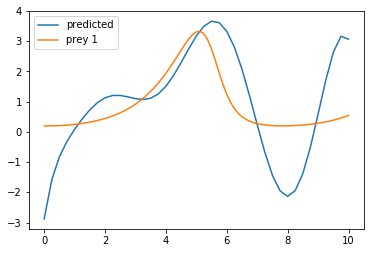

In [107]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(gp_sin.predict([[i,0.9,0.9]]))
set_parameter(alpha=0.9, delta=0.9, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

#### Precision : 

In [108]:
y_pred = gp_sin.predict(test_df[['time','alpha','delta']].values)
y_true = test_df['prey_data'].values
mse(y_true,y_pred)

45.962059445821154

### Matern

In [109]:
from time import time

t1 =time()
X = train_df[['time','alpha','delta']].values
y =train_df['prey_data'].values
kernel =Matern([0.2,0.2,0.2], (1e-2, 1e2), 2.5)
gp_matern = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_matern.fit(X, y)
t2=time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  11.789606809616089  for  320  points


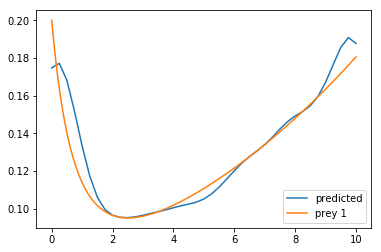

In [116]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(gp_matern.predict([[i,0.1,0.7]]))
set_parameter(alpha=0.1, delta=0.7, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

#### Precision : 

In [111]:
y_pred = gp_matern.predict(test_df[['time','alpha','delta']].values)
y_true = test_df['prey_data'].values
mse(y_true,y_pred)

33.21679416046133

### RationalQuadratic

In [112]:
from time import time

t1 =time()
X = train_df[['time','alpha','delta']].values
y =train_df['prey_data'].values
kernel =RationalQuadratic(0.5,alpha=0.2, length_scale_bounds=(1e-2, 1e2))
gp_rq = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_rq.fit(X, y)
t2=time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  2.2012598514556885  for  320  points


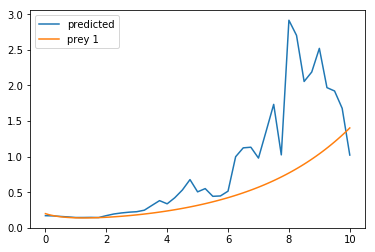

In [113]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(gp_rq.predict([[i,0.3,0.3]]))
set_parameter(alpha=0.3, delta=0.3, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

#### Précision :

In [114]:
y_pred = gp_rq.predict(test_df[['time','alpha','delta']].values)
y_true = test_df['prey_data'].values
mse(y_true,y_pred)

53.88435731717188

## 4D et n D

In [145]:
def sampled_data(number_of_sample=100, sample_type='lhs'):
    if sample_type == 'lhs':
        sampling = lhs(4, samples=number_of_sample, criterion='cm')
        sampling[:,0]=np.round(sampling[:,0]*10,1)

    output_data_frame = pd.DataFrame()
    for i in range (len(sampling)):
        set_parameter(alpha=sampling[i,1],delta=sampling[i,2], beta = sampling[i,3], DefaultComp_prey=0.2,time_step='0.1s')
        run_model()
        output_data = get_outputs()
        output_data_frame = pd.concat([output_data_frame, output_data],ignore_index=True)
    output_array = output_data_frame.values
    output_array[:,0]=np.round(output_data_frame.values[:,0],1)
    sampled_data = [row for row in output_array if row[[0,3,4,5]].tolist() in sampling.tolist()]
    sampled_data_df = pd.DataFrame(sampled_data,columns=['time','prey_data','predator_data','alpha','delta','beta','gamma'])
    return sampled_data_df

In [146]:
sampled_data_df = sampled_data(number_of_sample=100)

In [147]:
train, test = train_test_split(sampled_data_df.values,test_size=0.2)
train_df = pd.DataFrame(train,columns=['time','prey_data','predator_data','alpha','delta','beta','gamma'])
test_df =  pd.DataFrame(test,columns=['time','prey_data','predator_data','alpha','delta','beta','gamma'])

In [148]:
from time import time

t1 =time()
X = train_df[['time','alpha','delta','beta']].values
y =train_df['prey_data'].values
kernel =Matern([0.2,0.2,0.2,0.2], (1e-2, 1e2), 2.5)
gp_matern = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_matern.fit(X, y)
t2=time()
print("time to train : ",t2-t1," for ", len(X), " points")

time to train :  2.1368110179901123  for  400  points


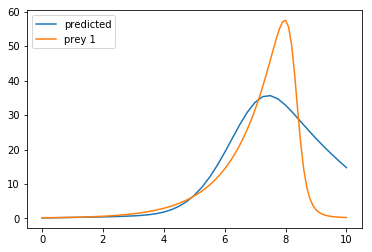

In [149]:
y=[]
time = np.linspace(0,10,41)
for i in time:
    y.append(gp_matern.predict([[i,0.8,0.1,0.5]]))
set_parameter(alpha=0.8, delta=0.1,beta =0.5, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

In [150]:
y_pred = gp_matern.predict(test_df[['time','alpha','delta','beta']].values)
y_true = test_df['prey_data'].values
mse(y_true,y_pred)

43.023656436111786

## Test predict a time serie

In [37]:
def sampled_data_output_time_serie(number_of_sample=100, sample_type='lhs'):
    from time import time
    t1 = time()
    if sample_type == 'lhs':
        sampling = lhs(4, samples=number_of_sample, criterion='cm')
        sampling[:,0]=np.round(sampling[:,0]*10,1)

    output_data_frame = pd.DataFrame()
    for i in range (len(sampling)):
        set_parameter(alpha=sampling[i,0],delta=sampling[i,1], beta = sampling[i,2],gamma= sampling[i,3], DefaultComp_prey=0.2,time_step='0.5s')
        run_model()
        output_data = get_outputs()
        prey_data = output_data['prey_data'].values
        alpha = output_data[['alpha','delta','beta','gamma']].values[0][0]
        delta = output_data[['alpha','delta','beta','gamma']].values[0][1]
        beta = output_data[['alpha','delta','beta','gamma']].values[0][2]
        gamma = output_data[['alpha','delta','beta','gamma']].values[0][3]


        output_data = pd.DataFrame({'alpha':alpha,
             'delta':delta,
                                    'beta':beta,
                                    'gamma':gamma,
             'prey_data': [prey_data]})
        output_data_frame = pd.concat([output_data_frame, output_data],ignore_index=True)
    t2 = time()
    #print('time to sample '+ str(number_of_sample) + ' : ' + str(t2-t1) +' secondes'  )
    return output_data_frame

In [40]:
sampled_data_df = sampled_data_output_time_serie(number_of_sample=200)

TypeError: can only concatenate str (not "int") to str

In [ ]:
sampled_data_df

In [ ]:
train, test = train_test_split(sampled_data_df.values,test_size=0.2)
train_df = pd.DataFrame(train,columns=['alpha','delta','beta','prey_data'])
test_df =  pd.DataFrame(test,columns=['alpha','delta','beta','prey_data'])

In [ ]:
from time import time

t1 =time()
X = train_df[['alpha','delta','beta']].values
y =train_df['prey_data'].values.tolist()
kernel =Matern([0.2,0.2,0.2], (1e-2, 1e2), 2.5)
gp_matern = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_matern.fit(X, y)
t2=time()
print("time to train : ",t2-t1," for ", len(X), " points")

In [ ]:
alpha = 0.2
delta =0.6
beta = 0.4
time = np.linspace(0,10,21)
y = gp_matern.predict([[alpha,delta,beta]])[0]
set_parameter(alpha=alpha, delta=delta,beta =beta, DefaultComp_prey=0.2,time_step='0.1s')
run_model()
plt.plot(time,y,label='predicted')
plot_outputs(plot_pred=False)

In [ ]:
y_pred = gp_matern.predict(test_df[['alpha','delta','beta']].values)
y_true = test_df['prey_data'].values.tolist()
mse(y_true,y_pred)